# Recommendations with IBM

In this notebook, I will be applying my recommendation skills on real data from the IBM Watson Studio platform.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from statsmodels.distributions.empirical_distribution import ECDF

import tests.project_tests as t

nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger', 'punkt_tab'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re

%matplotlib inline
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
dtype_dict = {'article_id': int}
df = pd.read_csv('../data/user_item_interactions.csv', dtype=dtype_dict)
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  int64 
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [6]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [7]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [8]:
article_distribution = pd.DataFrame(df.groupby(['email'])['article_id'].size())
article_distribution.columns = ['document_count']
article_distribution.sort_values(by='document_count',
                                 ascending=False,
                                 inplace=True)
article_distribution.head()

,document_count
email,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
a37adec71b667b297ed2440a9ff7dad427c7ac85,169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [9]:
article_distribution.describe()

,document_count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


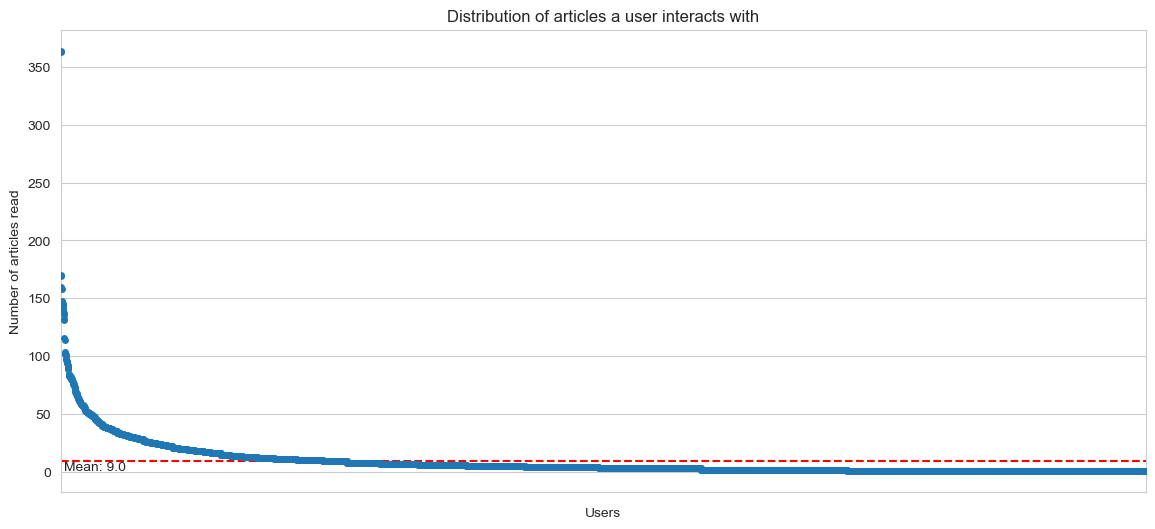

In [10]:
plt.figure(figsize=(14, 6))
avg_count = round(article_distribution['document_count'].mean(), 0)
ax = sns.stripplot(x='email',
                   y='document_count',
                   data=article_distribution,
                   jitter=False)
ax.axhline(avg_count, color='r', linestyle='--')
plt.text(avg_count + 300,
         avg_count, 'Mean: {}'.format(avg_count),
         fontsize=10,
         horizontalalignment='right',
         verticalalignment='top')
ax.set(xticklabels=[])
ax.set(xlabel='Users')
ax.set(title='Distribution of articles a user interacts with')
ax.set(ylabel='Number of articles read')
plt.show()

**Observations:** <br>
On average, users interact with 9 documents, which seems quite low.
The top 25% of users have much higher interactions with up to 350 documents.

In [11]:
# Fill in the median and maximum number of user_article interactions below
# 50% of individuals interact with ____ number of articles or fewer.
median_val = 3

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = 364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.

In [12]:
print('There are {} duplicate articles'.format(
    df_content.article_id.duplicated().sum()))

There are 5 duplicate articles


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(['article_id'], keep='first', inplace=True)
print('There are {} duplicate articles'.format(
    df_content.article_id.duplicated().sum()))

There are 0 duplicate articles


In [14]:
# Are there documents with duplicate titles?
print('There are {} duplicate articles'.format(
    df_content.doc_full_name.duplicated().sum()))

There are 0 duplicate articles


In [15]:
# In addition, remove null values from df_contents
df_content.dropna(subset=['doc_description', 'doc_body'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

**a.** The number of unique articles that have an interaction with a user.

In [16]:
df.article_id.nunique()

714

**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>

In [17]:
# b. The number of unique articles in the dataset
# (whether they have any interactions or not)
df_content.article_id.nunique()

1034

**c.** The number of unique users in the dataset. (excluding null values) <br>

In [18]:
df.email.nunique()

5148

**d.** The number of user-article interactions in the dataset.

In [19]:
df.shape

(45993, 3)

In [20]:
unique_articles = 714  # The number of articles with interactions
total_articles = 1051  # Number of total articles
unique_users = 5148  # The number of unique users
user_article_interactions = 45993  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [21]:
# display the top 10 viewed articles
df.article_id.value_counts()[:10]

article_id
1429    937
1330    927
1431    671
1427    643
1364    627
1314    614
1293    572
1170    565
1162    512
1304    483
Name: count, dtype: int64

In [22]:
# The most viewed article in the dataset
# as a string with one value following the decimal
most_viewed_article_id = '1429.0'

# The most viewed article in the dataset was viewed how many times?
max_views = 937

In [23]:
# If you stored all your results in the variable names above,
# you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [24]:
# extra checks for null values in df_content
df_content.isnull().sum()

doc_body           0
doc_description    0
doc_full_name      0
doc_status         0
article_id         0
dtype: int64

In [25]:
# Are there any interactions with articles without a body?
null_content = df_content[df_content.doc_body.isnull()]
null_interactions = null_content.merge(df, how='inner', on='article_id')
len(null_interactions)

0

In [26]:
df_content.dropna(subset=['doc_body'], inplace=True)

In [27]:
# No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df):
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1

        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper(df)
del df['email']
df['user_id'] = email_encoded

In [30]:
# write the cleaned-up file back to disk
df.to_csv('../data/user_item_interactions_clean.csv')

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [31]:
# Which documents does user 1 like to read?
set(df.loc[df['user_id'] == 1]['title'])

{'access db2 warehouse on cloud and db2 with python',
 'analyze db2 warehouse on cloud data in rstudio in dsx',
 'apache spark lab, part 1: basic concepts',
 'categorize urban density',
 'classify tumors with machine learning',
 'country statistics: life expectancy at birth',
 'deep learning with tensorflow course by big data university',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'introducing ibm watson studio ',
 'introduction to market basket analysis in\xa0python',
 'jupyter notebook tutorial',
 'new shiny cheat sheet and video tutorial',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning',
 'python for loops explained (python for data science basics #5)',
 'python if statements explained (python for data science basics #4)',
 'rapidly build machine learning fl

In [32]:
set(df.loc[df['user_id'] == 3193]['title'])

{'a tensorflow regression model to predict house values',
 'deep learning from scratch i: computational graphs',
 'dsx: hybrid mode',
 'total population by country',
 'uci: sms spam collection',
 'use xgboost, scikit-learn & ibm watson machine learning apis'}

In [33]:
set(df.loc[df['user_id'] == 4178]['title'])

{'breast cancer detection with xgboost, wml and scikit',
 'deploy your python model as a restful api',
 'from scikit-learn model to cloud with wml client',
 'visualize car data with brunel'}

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.`Return the **n** top articles ordered with most interactions as the top.

In [34]:
def get_top_articles(n, df=df):
    """
    Find top n articles from interactions

    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    """

    top_article_titles = []
    top_articles = get_top_article_ids(n, df)

    for id in top_articles:
        title = df.loc[df['article_id'] == id]['title'][:1].values[0]
        top_article_titles.append(title)

    # Return the top article titles from df (not df_content)
    return top_article_titles


def get_top_article_ids(n, df=df):
    """
    Find the top n article id's from interactions

    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """

    top_articles = list(df.article_id.value_counts()[:n].index)

    # Return the top article ids
    return top_articles

In [35]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


##### Are all article_id's that have interactions also present in the content database ?

In [36]:
top_articles = np.array(df.article_id.value_counts().index)
len(top_articles)

714

In [37]:
articles_in_content = np.array(df_content.article_id.unique())
print(len(articles_in_content))
articles_in_content

1034


array([   0,    1,    2, ..., 1047, 1048, 1050])

In [38]:
top_articles_not_in_content = np.setdiff1d(
    top_articles, articles_in_content)

print(len(top_articles_not_in_content))

277


In [39]:
df.user_id.value_counts()[:100]

user_id
23      364
3782    363
98      170
3764    169
203     160
       ... 
3637     59
125      59
668      59
321      59
1059     59
Name: count, Length: 100, dtype: int64

**Observation:**
277 articles are missing in df_content that are present in df.
We have interactions but not details about the content.
Because this is a strict template provided by Udacity,
I will have these records in this notebook,
but will remove in them in the webapp as next step

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [40]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns
    with 1 values where a user interacted with an article and a 0 otherwise
    """

    user_item = pd.crosstab(df.user_id, df.article_id)
    user_item = user_item.where(user_item == 0, 1)

    return user_item


user_item = create_user_item_matrix(df)

In [41]:
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149,  "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714,  "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36,  "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [43]:
def find_similar_users(user_id, user_item=user_item):
    """
    Computes the similarity of every pair of users based on the dot product

    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users
                    (largest dot product users) are listed first
    """

    # compute the similarity of each user to the provided user
    input_user_series = user_item.loc[user_id]
    dot_similarity = input_user_series.dot(np.transpose(user_item))

    # sort by similarity
    dot_similarity.sort_values(ascending=False, inplace=True)

    # create list of just the ids
    most_similar_users = list(dot_similarity.index)

    # drop user id that is same as input
    most_similar_users.remove(user_id)

    # return a list of the users in order from most to least similar
    return most_similar_users


def find_similar_users_knn(user_id, user_item=user_item, n=10):
    """
    Computes the similarity of every pair of users based on the KNN

    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users
                    (largest dot product users) are listed first
    """
    knn = NearestNeighbors(n_neighbors=n+1,
                           algorithm='auto',
                           metric='cosine',
                           n_jobs=-1)
    knn.fit(user_item)
    # contains indexes of similar users
    neighbors = knn.kneighbors(user_item.loc[[user_id]],
                               return_distance=False).squeeze()
    # get user_ids
    userids = user_item.iloc[neighbors].index.values.tolist()
    userids.remove(user_id)
    return userids

In [44]:
# Do a spot-check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [45]:
# Do a spot-check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users_knn(1, n=10)))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users_knn(3933, n=5)))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users_knn(46, n=3)))

print("The 10 most similar users to user 4178 are: {}".format(find_similar_users_knn(4178, n=10)))
print("The 10 most similar users to user 4999 are: {}".format(find_similar_users_knn(4999, n=5)))

The 10 most similar users to user 1 are: [3933, 4201, 46, 5034, 824, 253, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 4201, 46, 824, 5034]
The 3 most similar users to user 46 are: [4201, 790, 5077]
The 10 most similar users to user 4178 are: [2417, 99, 4981, 1938, 2570, 2569, 2566, 2568, 1510, 2567]
The 10 most similar users to user 4999 are: [2826, 2813, 3190, 318, 339]


**Conclusion:**
KNN does not perform as well as the dot product.
In the end, KNN is using dot product as well,
but without considering magnitude.
As magnitude is important for popularity,
it's better to continue with only dot product to measure similarity.

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [46]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    """

    article_names = []

    for id in article_ids:
        id = int(id)
        title = df.loc[df.article_id==id, 'title'].unique()
        article_names.append(title[0])

    # Return the article names associated with the list of article ids
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """

    # get a list of movies user has read
    user_id = int(user_id)
    docs_read = user_item.loc[user_id]
    article_ids = list(map(str, docs_read[docs_read  == 1].index))
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def get_user_articles2(user_id, user_item=user_item):
    """
    Provides a list of the article_ids and article titles that have been seen by a user

    Copy of get_user_articles but with user_id as an integer instead

    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)
    """

    # get a list of movies user has read
    user_id = int(user_id)
    docs_read = user_item.loc[user_id]
    article_ids = list(docs_read[docs_read  == 1].index)
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10, knn=False):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily
    """

    docs_read = user_item.loc[user_id]
    docs_read = docs_read[docs_read  == 1].index

    # list of user id's that read similar documents to the requested user
    if knn:
        nearest_neighbors = find_similar_users_knn(user_id)[:m]
    else:
        nearest_neighbors = find_similar_users(user_id)[:m]

    # reduce the user_item matrix to only nearest neighbors
    neighbors_docs = user_item.reindex(nearest_neighbors)

    # get the articles read the most by neighbors with highest score
    recs = neighbors_docs.sum().sort_values(ascending=False)

    # drop articles read already
    recs = recs.drop(docs_read, errors='ignore')

    # get titles
    titles = get_article_names(recs[:m].index)

    return titles # return your recommendations for this user_id

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024', '1176', '1305', '1314', '1422', '1427'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320', '232', '844'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320', '232', '844'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024', '1176', '1305', '1314', '1422', '1427'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
def get_top_sorted_users(user_id, df=df, user_item=user_item, knn=False):
    """
    Get most similar users

    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    """

    dot_similarity = pd.DataFrame()

    # list of user id's that read similar documents to the requested user
    if knn:
        neighbors = find_similar_users_knn(user_id)
        knn = NearestNeighbors(n_neighbors=100, algorithm='auto', metric='cosine', n_jobs=-1)
        knn.fit(user_item)
        # contains indexes of similar users
        distance, neighbors = knn.kneighbors(user_item.loc[[user_id]], return_distance=True)
        # get user_ids
        userids = user_item.iloc[neighbors.squeeze()].index.values.tolist()
        similarity = pd.DataFrame({'similarity': distance.squeeze()}, index=userids)

    else:
	    # compute the similarity of each user to the provided user
        input_user_series = user_item.loc[user_id]
        similarity = input_user_series.dot(np.transpose(user_item))

    # sort user_ids by top interactions
    top_article_interactions = df.user_id.value_counts()

    # merge and sort similarities and interactions
    neighbors_df = pd.concat([similarity, top_article_interactions], axis=1)
    neighbors_df.columns = ['similarity', 'num_interactions']
    neighbors_df.drop(user_id, axis=0, inplace=True)
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, knn=False):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """

    # get all the documents user has read
    docs_read = user_item.loc[user_id]
    docs_read = docs_read[docs_read  == 1].index

    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item, knn=knn)

    nearest_user_id = neighbors_df[:m+10].index.values.tolist()

    # reduce the user_item matrix to only nearest neighbors
    neighbors_docs = user_item.reindex(nearest_user_id)

    # get the documents read the most by neighbors with highest score
    neighbors_docs = neighbors_docs.sum().sort_values(ascending=False)

    # merge and sort similarities and interactions
    top_article_interactions = df.article_id.value_counts()
    similar_articles = pd.concat([neighbors_docs, top_article_interactions], axis=1)
    similar_articles.columns = ['similarity', 'num_interactions']
    similar_articles = similar_articles.drop(docs_read, errors='ignore')
    similar_articles.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)

    # list of recommended article ids
    recs = similar_articles[:m].index.values.tolist()

    # list of recommended article titles
    rec_names = get_article_names(recs)

    return recs, rec_names

In [49]:
# Let's try to test this function
# Actual documents read by user 4999, it's easy to judge manually as the user read only 3 documents
get_user_articles2(4999)[1]

['deploy your python model as a restful api',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation']

In [50]:
# get_top_sorted_users(4999, knn=True)
user_user_recs_part2(4999, knn=True)

([732, 1338, 1360, 1169, 1429, 1364, 1420, 898, 1330, 1314],
 ['rapidly build machine learning flows with dsx',
  'ml optimization using cognitive assistant',
  'pixieapp for outlier detection',
  'annual precipitation by country 1990-2009',
  'use deep learning for image classification',
  'predicting churn with the spss random tree algorithm',
  'use apache systemml and spark for machine learning',
  'neural language modeling from scratch (part 1)',
  'insights from new york car accident reports',
  'healthcare python streaming application demo'])

In [51]:
# get_top_sorted_users(4999, knn=False)
user_user_recs_part2(4999, knn=False)

([1360, 1364, 1429, 1314, 1351, 1393, 1185, 1368, 1163, 1338],
 ['pixieapp for outlier detection',
  'predicting churn with the spss random tree algorithm',
  'use deep learning for image classification',
  'healthcare python streaming application demo',
  'model bike sharing data with spss',
  'the nurse assignment problem',
  'classify tumors with machine learning',
  'putting a human face on machine learning',
  'analyze open data sets with spark & pixiedust',
  'ml optimization using cognitive assistant'])

Conclusion:
Dot product is a better metric than knn for this use case.
KNN using cosine is actually also using dot product but is normalized by magnitude.
In our use case, magnitude gives better results as popularity matters.

In [52]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1162, 1314, 1351, 1330, 1429, 1364, 1271, 1368, 1172, 1276]

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'healthcare python streaming application demo', 'model bike sharing data with spss', 'insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'customer demographics and sales', 'putting a human face on machine learning', 'apache spark lab, part 3: machine learning', 'deploy your python model as a restful api']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [53]:
get_top_sorted_users(1).index.values.tolist()[:1]

[3933]

In [54]:
get_top_sorted_users(131).index.values.tolist()[:10]

[3870, 3782, 23, 203, 4459, 98, 3764, 49, 3697, 242]

In [55]:
### Tests with a dictionary of results
user1_most_sim =  3933 # Find the user that is most similar to user 1
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [56]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user or a new document,
collaborative filtering does not work well to make predictions,
as it's using historical patterns to make predictions.

I propose two options for recommendations to new users:
1) Ranked-based recommendations <br>
like we did in Part II in function
`get_top_articles` to propose the most popular articles.

2) Content-based recommendations <br>
Use NLP techniques
to propose articles to the user based on word count and semantic search,
based on input search criteria provided by the user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [57]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?
# As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to.
new_user_recs = get_top_article_ids(n=10)
# convert to a floated string to match Udacity testing
new_user_recs = [str(float(x)) for x in new_user_recs]
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [58]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is
to perform a ranking of the highest ranked articles
associated with some input term.

Use NLP techniques to convert document texts into words.

Merge `doc_body`, `doc_description`
and `doc_full_name` to improve search term performance.

In [59]:
# first lets enhance df_content
# for content-based recommendations, merge title, description and body
df_content['doc_body_all'] = (
    df_content[df_content.columns[:]].apply(
        lambda x: ','.join(x.astype(str)), axis=1))

df_content.columns

Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id', 'doc_body_all'],
      dtype='object')

In [60]:
def tokenize(text):
    """ Summarize text into words whilst cleaning it up

    Most important functions:
    - Summarize url links starting with http or www to a common phrase 'url
    - Summarize email addresses to a common phrase 'email'
    - Get rid of new lines `\n'
    - Remove all words that are just numbers
    - Remove all words that contain numbers
    - Cleanup basic punctuation like '..', '. .'
    - Remove punctuation
    - Remove words that are just 1 character long after removing punctuation
    - Use lemmatization to bring words to the base

    Args:
        text: string, Text sentences to be split into words

    Return:
        clean_tokens: list, List containing most crucial words
    """

    # Replace urls starting with 'https' with placeholder
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # replace urls with a common keyword
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')

    # Replace urls starting with 'www' with placeholder
    url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url')

    # replace emails with placeholder
    email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'
    detected_emails = re.findall(email_regex, text)
    for email in detected_emails:
        text = text.replace(email, 'email')

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")
    text = text.replace("..", ".")
    text = text.replace(". .", ".")
    text = text.replace(" ,.", ".")

    text = re.sub(r'\s+', ' ', text).strip()

    # normalize text by removing punctuation, remove case and strip spaces
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = text.lower().strip()

    # remove numbers
    text = re.sub(r'\d+', '', text)

    #  split sentence into words
    tokens = word_tokenize(text)

    # Remove stopwords, e.g. 'the', 'a',
    tokens = [w for w in tokens if w not in stopwords.words("english")]

    # take words to their core, e.g. children to child, organizations to organization
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok, wordnet.VERB)
        # ignore tokens that have only 1 character or contains numbers
        if len(clean_tok) >= 2 & clean_tok.isalpha():
            clean_tokens.append(clean_tok)

    return clean_tokens

In [61]:
def create_word_count_matrix(df=df_content.copy(deep=True), column='doc_body'):
    """
    Create a word count matrix for a dataframe column containing text

    Input:
    df: pandas dataframe containing document texts, with identifier 'article_id'
    column: string -> column to convert to word counts

    Output:
    tfidf_df: pandas dataframe containing the word count matrix

    """
    df.set_index('article_id', inplace=True)

    # Create a word count matrix by article
    tfidf_vectorizer = TfidfVectorizer(min_df=3,
                                       max_df=0.6,
                                       tokenizer=tokenize,
                                       token_pattern=None,
                                       max_features=5000)
    vectorized_data = tfidf_vectorizer.fit_transform(df[column])
    tfidf_df = pd.DataFrame(vectorized_data.toarray(),
                            columns=tfidf_vectorizer.get_feature_names_out(),
                            index=df.index)
    return tfidf_df, tfidf_vectorizer

In [62]:
tfidf_df, tfidf_vectorizer = create_word_count_matrix(df_content.copy(deep=True), column='doc_body_all')
tfidf_df.head()

,aa,aapl,aaron,ab,abdullah,ability,able,abline,abs,absolute,...,young,youtube,ytd,yyyy,z,zero,zip,zone,zoo,zoom
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.050284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.018488,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.047975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
def print_content_recommendations(ids, df=df_content):
    """
    Print document titles and descriptions based on a list of recommended article_ids

    Input:
    ids: list -> list of input article ids
    df: pandas dataframe containing document texts, with identifier column 'article_id'

    Output:
    Print article id, document name and description
    """

    print('Possible recommendations are:')
    for id in ids:
        doc_full_name = df.loc[df['article_id'] == id, ['doc_full_name', 'doc_description']].values[0]
        print('{:>6}: {:>12}.  {:>12}'.format(id, doc_full_name[0], doc_full_name[1]))


def make_content_recs(input_search_text, tfidf_vectorizer=tfidf_vectorizer, tfidf_df=tfidf_df, n=10, df=df):
    """
    Content-based recommendations based on text-based similarity

    User input any search text

    INPUT:
    input_search_text: string, any text a user input to search for documents

    OUTPUT:
    content_ids: list, List containing article_id recommendations
    content_descriptions: list, List containing article descriptions

    """
    input_search_text = tfidf_vectorizer.transform([input_search_text])
    similarity = cosine_similarity(input_search_text, tfidf_df)
    cosine_similarity_df = pd.DataFrame(similarity, columns=tfidf_df.index)
    ids = cosine_similarity_df.loc[0].sort_values(ascending=False).index.values[:n].tolist()
    print_content_recommendations(ids)

In [64]:
make_content_recs('Why machine learning?')

Possible recommendations are:
   967: ML Algorithm != Learning Machine.  How easy it is to build a learning machine? Shouldn't one just hire some Machine Learning PhDs and have them run their algorithms?  Well, this is most probably a good idea, but it won't be enough.  I'll try to explain why in this blog entry. Before answering our questions, let's define what we are dealing with.  A Learning Machine is a machine (a software, a web site, a mobile app, a robot, pick your favorite) that performs a task, and that gets better and better as it performs it.  In recent years, some learning machines made headlines.  For instance, IBM Watson defeated best humans at...
  1035: Machine Learning for the Enterprise..  In my last blog “Business differentiation through Machine Learning” I introduced and described the concepts of machine learning. We traced its origins from a computer science project to Watson show…
   800: Machine Learning for the Enterprise.  In my last blog “Business differentiat

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

The content-based recommendation system is using a text-based similarity search between user input and the text body of each document.
Documents are recommended
where the most words are matching the input criteria.
The following steps are followed:

1) Create a tokonizer to clean-up the text, e.g. lower case, remove accents, stopwords, line feeds, numbers etc
2) Use the tokenizer in sklearn's `TdidfVectorizer()` feature extraction function to create a Document-Term matrix, with words and their frequency as columns and article_id as index
3) Convert the user input search text using the same model as fitted in step 2. This create a comparable document-term matrix as above with the same shape.
4) Use cosine similarity to compare the user input with the documents to find the most similar term frequencies
5) Propose the top n documents with highest cosine score to the user

The solution is working pretty well,
however,
it's based on a static word count similarity
that does not understand semantics or context.
Using AI and embeddings would allow a much smarter and more modern recommendation system.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [65]:
# make recommendations for a brand-new user
make_content_recs('XGBOOST')

Possible recommendations are:
   130: Feature importance and why it's important.  Feature importance in machine learning using examples in Python with xgboost. Getting better performance from a model with feature pruning.
  1018: 7 types of job profiles that makes you a Data Scientist.  What exact skills do companies look for when they are recruiting a Data Scientist.
   415: Using Machine Learning to Predict Value of Homes On Airbnb.  Data products have always been an instrumental part of Airbnb’s service. However, we have long recognized that it’s costly to make data products. For example, personalized search ranking enables…
   932: Pseudo-labeling a simple semi-supervised learning method.  Using pseudo-labeling a simple semi-supervised learning method to train machine learning models with sci-kit learn and Python (examples with code).
   253: Lifelong (machine) learning: how automation can help your models get smarter over time.  Imagine you’re interviewing a new job applicant who 

In [66]:
# make a recommendation for a user who only has interacted with article id '1427.0'
# get the title of the article that was read
title = df.loc[df['article_id'] == 1427, ['title']][:1].squeeze()
print('Title the user has read is: {}\n'.format(title))

# use this title to get similar articles
make_content_recs(title)

Title the user has read is: use xgboost, scikit-learn & ibm watson machine learning apis

Possible recommendations are:
    30: How open API economy accelerates the growth of big data and analytics.  An open API is available on the internet for free. We review the growth of API economy and how organizations have been realizing the potential of open APIs in transforming their business. 
   685: Working with data flows using  Watson Data APIs.  IBM Watson  offers a collection of REST APIs for creating, running, managing, and troubleshooting data flows to allow your applications to easily integrate with Data Refinery.
   805: Machine Learning for everyone.  Today we take another step toward making Machine Learning simple and accessible for everyone with our launch of IBM Watson Machine Learning. Watson Machine Learning is designed to make AI and Machine…
   437: IBM Watson Machine Learning: Get Started.  Watch this video to see how to get started with IBM Watson Machine Learning (WML) by 

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [67]:
# Load the matrix here
user_item_matrix = pd.read_pickle('../data/user_item_matrix.p')
user_item_matrix.shape, user_item.shape

((5149, 714), (5149, 714))

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [68]:
# calculate svd predictions as per Udacity lesson
u, s, vt = np.linalg.svd(np.array(user_item))
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

In the Udacity lesson,
we use SVDs
to predict the ratings of missing values,
where in this exercise we are not dealing with missing values but binary indicators
indicating if a user read a document or not.

SVD in this use case could make sense
to investigate latent features to detect patterns in the data,
reduce dimensionality to improve overall performance,
make predictions for new users and documents.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

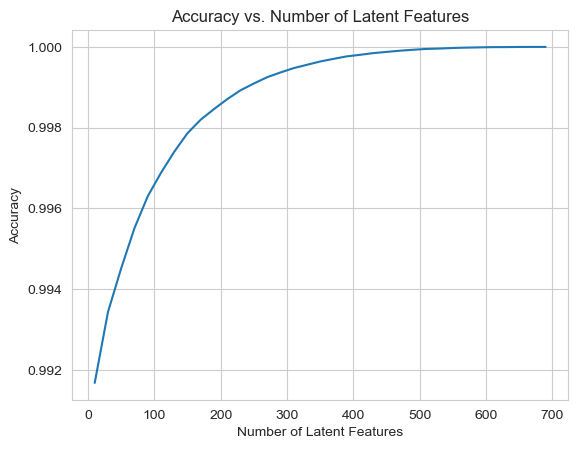

In [69]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs), axis=0), axis=0)
    sum_errs.append(err)
    

max_error = user_item.shape[0] * user_item.shape[1]
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/max_error)
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [70]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test, correct_history=True):
    """
    Create training and testing user-item matrix

    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    """
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx  = user_item_test.index.values.tolist()
    test_arts = user_item_test.columns.values.tolist()

    # find common users and articles
    common_users = np.intersect1d(user_item_train.index, user_item_test.index)
    common_articles = np.intersect1d(user_item_train.columns, user_item_test.columns)

    # keep only common users and articles in the testing dataset
    user_item_test = user_item_test.loc[common_users, common_articles]

    # correct the history in the test dataset
    # If a user read a document in the past in the training dataset,
    # set the document to read also in the test dataset.
    if correct_history:
        for user in common_users:
            for article in common_articles:
                if (user_item_train.loc[user, article] == 1) & (user_item_test.loc[user, article] == 0):
                    user_item_test.loc[user, article] = 1

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)
user_item_train.shape, user_item_test.shape

((4487, 714), (20, 574))

In [71]:
# 1. How many users can we make predictions for in the test set?
# How many users in the test dataset are also in the training dataset?
# (We can only make predictions for these users)
pred_user_ids = user_item_train.loc[user_item_train.index.isin(test_idx)].index.values.tolist()
print('We can predict for {} users: {}'.format(len(pred_user_ids), pred_user_ids))

We can predict for 20 users: [2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968, 3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487]


In [72]:
common_users = np.intersect1d(user_item_train.index, user_item_test.index)

In [73]:
common_articles = np.intersect1d(user_item_train.columns, user_item_test.columns)
len(common_articles)

574

In [74]:
# 2. How many users in the test set are we not able
# to make predictions for because of the cold start problem?
# How many users are in the test dataset
len(test_idx) - len(pred_user_ids)

662

In [75]:
# 3. How many articles can we make predictions for in the test set?
# How many articles in the test dataset are also in the training dataset?
# (We can only make predictions for these)
user_item_train.loc[:, test_arts].shape[1]

574

In [76]:
# 4. How many articles in the test set are we not able
# to make predictions for because of the cold start problem?
len(test_arts) - user_item_train.loc[:, test_arts].shape[1]

0

In [77]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d,
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.

In [78]:
# Lets make sure we corrected historical data correctly focussing on 1 user
compare = pd.DataFrame({'train': user_item_train.loc[4487, test_arts], 'test': user_item_test.loc[4487, test_arts]})
compare = compare.loc[~(compare==0).all(axis=1)]
compare

,train,test
article_id,,
8,1,1
411,1,1
470,1,1
477,1,1
542,1,1
730,1,1
903,1,1
1053,0,1
1166,1,1


In [79]:
compare.sum()

train    14
test     17
dtype: int64

In [80]:
def determine_latent_features(df_train, df_test, test_idx=test_idx, test_arts=test_arts):
    """
    Determine how many SVD latent features maximizes accuracy and MSE the best.

    Use the train dataset to find U, S, and V transpose using SVD.
    Then find the subset of rows in the test dataset
    that you can predict
    using this matrix decomposition with different numbers of latent features
    to see how many features makes sense
    to keep based on the accuracy and mse on the test data.

    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    test_idx - test user ids present in both test and training datasets (rows)
    test_arts - test articles ids present in both test and training datasets (columns)

    OUTPUT:
    num_latent_feats: array of k latent features used for prediction
    sum_errs:
    list containing accuracy by nr of latent features used
    mse: list containing mse by nr of latent features used
    """

    num_latent_feats = np.arange(10, len(common_articles)+10, 50)
    train_acc_errs = []
    test_acc_errs = []
    train_mse = []
    test_mse = []

    for k in num_latent_feats:

        # TRAINING PREDICTIONS
        # Decompose the matrix using training dataset with SVD with k latent features
        u_train, s_train, vt_train = svds(np.array(df_train), k=k)

        # correct shape of s (latent features)
        s_train = np.diag(s_train)

        # predict if user will read the article using dot product
        training_prediction = np.around(np.dot(np.dot(u_train, s_train), vt_train), 0)

        # compute error for each prediction to actual value
        train_difference = np.subtract(df_train, training_prediction)

        # total errors and keep track of them
        # accuracy
        train_acc_err = np.sum(np.sum(np.abs(train_difference), axis=0), axis=0)
        train_acc_err = 1 - (train_acc_err / (training_prediction.shape[0]*training_prediction.shape[1]))
        train_acc_errs.append(train_acc_err)

        # mse error
        train_mse_err = mean_squared_error(df_train, training_prediction)
        train_mse.append(train_mse_err)

        # TESTING PREDICTIONS
        # filter training dataset predictions to only common users and articles
        # (one could also directly just filter the training predictions)
        row_idx = df_train.index.isin(test_idx)
        col_idx = df_train.columns.isin(test_arts)
        u_test = u_train[row_idx, :]
        vt_test = vt_train[:, col_idx]
        testing_prediction = np.around(np.dot(np.dot(u_test, s_train), vt_test), 0)
        test_difference = np.subtract(df_test, testing_prediction)

        # total errors and keep track of them
        # accuracy
        test_acc_err = np.sum(np.sum(np.abs(test_difference), axis=0), axis=0)
        test_acc_err = 1 - (test_acc_err / (testing_prediction.shape[0] * testing_prediction.shape[1]))
        test_acc_errs.append(test_acc_err)

        # mse
        test_mse_err = mean_squared_error(df_test, testing_prediction)
        test_mse.append(test_mse_err)

    return num_latent_feats, train_acc_errs, test_acc_errs, train_mse, test_mse

num_latent_feats, train_acc_errs, test_acc_errs, train_mse, test_mse = determine_latent_features(user_item_train, user_item_test, test_idx)

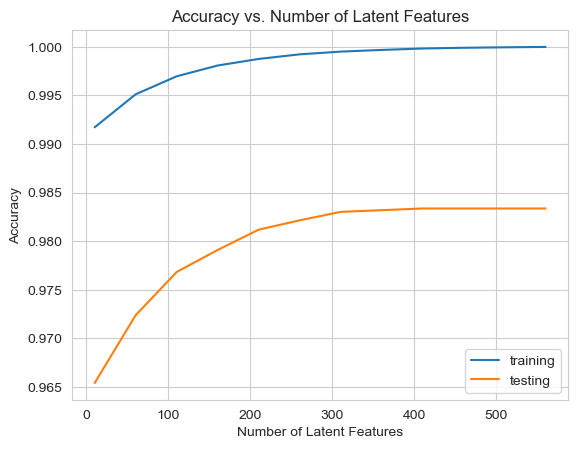

In [81]:
plt.plot(num_latent_feats, train_acc_errs, label='training')
plt.plot(num_latent_feats, test_acc_errs, label='testing')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

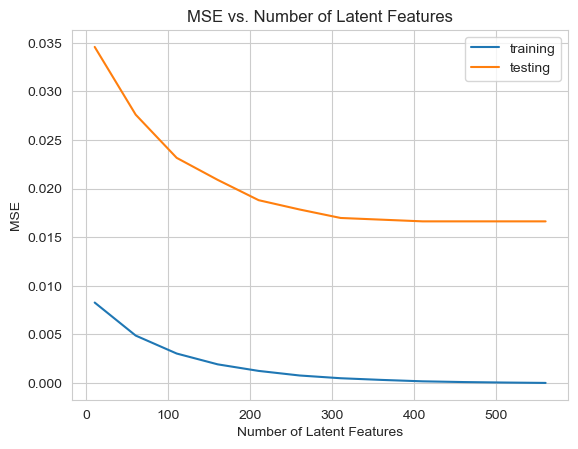

In [82]:
# plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.plot(num_latent_feats, train_mse, label='training')
plt.plot(num_latent_feats, test_mse, label='testing')
plt.xlabel('Number of Latent Features')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

The following steps were followed to predict which documents a user might like:
1. Split data into training and testing datasets.
*  Filter the testing dataset to contain only common users and articles in both training and testing datasets.
*  Correct historical data in the testing dataset. If a user read a document in the past in the training dataset, set it to read in the testing dataset too.

2.  Prediction
The full training dataset is used with all users and articles
to find all latent features
that describes the underlying relationships and patterns in the data.

3.  Evaluate
Once we established all the relationships during the training steps,
we can use it to predict more accurately user preferences using the test dataset.
The training predictions are filtered
to only include the common users and articles in both datasets.
These predictions are compared to the test dataset to calculate accuracy and MSE error

<br>**Conclusions on predictions:**

- Both the training and testing predictions show improvement in accuracy
as the latent features increase.
Note: If we do not correct historical data in the test dataset,
it gives a false impression that the accuracy goes down, because
read documents in the past show as '0' and are compared against predicted values of '1'.

- MSE error goes down as latent features increase.

- 300 Latent features looks like a good feature selection to use,
as improvement slows down after this.

<br>**How to proof if recommendations are an improvement to how users find articles?**

Use A/B testing to compare recommendations with users' natural behavior.
Metrics: Number of documents interacted with per user

Divide users with low interactions randomly into two groups.
Group A receives no recommendations and group B receives recommendations.

In Part I above,
we observed that users up to the 75th percentile only interacted with nine documents.
Can we improve this interaction?
Filter data using the first 75th percentile only,
to exclude users that interacts frequently anyhow to avoid bias.
Divide these filtered users into each group randomly.

<br>**Hypothesis test for Invariant Metric:**<br>
Before we start our experiment,
make sure the two groups have users who behave similarly.
Make sure the average interactions are not significantly different between the two groups.
Significance level is 0.05

$H_0: A_{avg_interactions} - A_{avg_interactions}> = 0$

$H_1: B_{avg_interactions} - A_{avg_interactions}> <> 0$


<br>**Hypothesis to test recommendation improvement:**<br>
Ideally we would like
to see an improvement in interactions in group B
that received recommendations.
The significance level is 0.05

<br>$H_0: B_{interactions} - A_{interactions}> <= 0$

$H_1: B_{interactions} - A_{interactions}> > 0$


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/site-packages/nbconvert/__main__.py", line 5, in <module>
    main()
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/opt/anaconda3/envs/recommendations/lib/python3.10/site-packages/nbconvert/n

1